# CNN Regression Model

In [170]:
import pandas as pd
from Data_preparation_Library import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from time import time
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from random import choice
from scipy import signal
from pickle import load,dump
import math
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

## Sample

<AxesSubplot:title={'center':'Velocity'}>

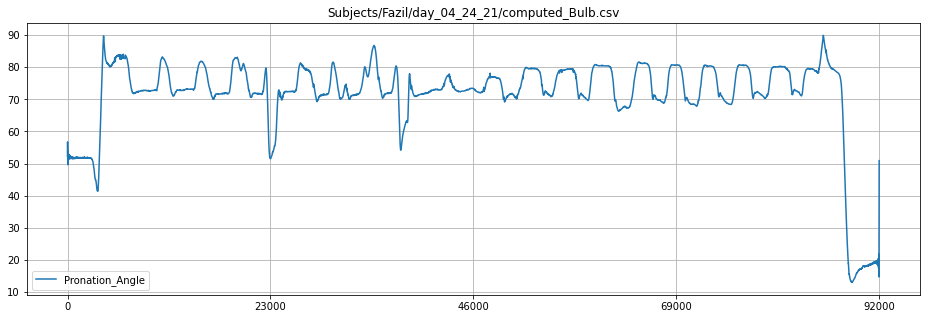

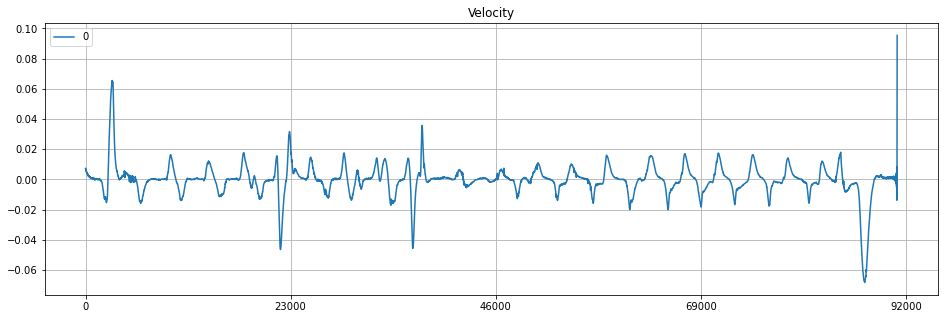

In [171]:
file = 'Subjects/Fazil/day_04_24_21/computed_Bulb.csv'
emg_labels = ['EMG1','EMG2','EMG3','EMG4','EMG5','EMG6','EMG7','EMG8']
angle_lables = ['Pronation_Angle'] # 'Pronation_Angle','Flexion_Angle',  'Radial_Angle','Elbow_Joint_Angle'
df = pd.read_csv(file,index_col=0)
df[angle_lables].plot(figsize=(16,5),title=file,grid=True,xticks=np.linspace(0,len(df),5))

arr = np.diff([0]+list(df['Pronation_Angle']))
# arr = arr/df.index
b,a = signal.butter(1, 1,fs=2000)
arr = signal.lfilter(b, a,arr)
pd.DataFrame(arr[1000:]).plot(figsize=(16,5),title='Velocity',grid=True,xticks=np.linspace(0,len(df),5))

## Prep Data

In [172]:
window = 400

In [173]:
files = []
subjects = ['Fazil/day_04_24_21','Nikhil/day_05_13_21'] #'Fazil/day_04_14_21'
for subj in subjects:
    path = 'Subjects/'+subj
    # trial_names = ['Bulb','Hammer'] # 'Bulb','Hammer' ,'Cup','Screw'
    trial_names = ['Bulb','Hammer' ,'Cup','Screw'] #,
    for exp in trial_names:
        for i in range(3):
            if(i==0):
                files.append(path+'/computed_'+exp+'.csv')
            else:
                files.append(path+'/computed_'+exp+'0'+str(i)+'.csv')
files

['Subjects/Fazil/day_04_24_21/computed_Bulb.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Bulb02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Hammer02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Cup02.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw01.csv',
 'Subjects/Fazil/day_04_24_21/computed_Screw02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Bulb02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer01.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Hammer02.csv',
 'Subjects/Nikhil/day_05_13_21/computed_Cup.csv',
 'Subjec

In [174]:
files = files[1:]

In [175]:
files_df = []
for file in files:
    files_df.append(pd.read_csv(file,index_col=0))

In [176]:
files_df = filter_df(files_df)

In [177]:
X, y = multiple_prep_data_velocity(files_df,window,interval=10,Normalize=False,rms=False,angle_label ='Pronation_Angle')
X.shape

(142280, 400, 8)

## Time Window Normalize

In [178]:
X_mean = np.zeros(X[0].shape)
for x in X:
    X_mean = X_mean + x
X_mean = X_mean/X.shape[0]
X_std = np.sqrt(variance(X))
np.save('mean_std',np.array([X_mean,X_std]))

In [179]:
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

## Test Train Split

In [180]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.2)
for data in [X_train, X_test, y_train, y_test]:
    print(data.shape)

(113824, 400, 8)
(28456, 400, 8)
(113824, 1)
(28456, 1)


# Neural Network Regression

In [200]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
n_outputs = 1

In [201]:
n_outputs = 1
in_shape = (X.shape[1],X.shape[2])

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=in_shape))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
# model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))

model.add(Conv1D(filters=8, kernel_size=3, activation='relu'))
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
model.add(Dropout(0.5))
# model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
# model.add(Dense(10,activation='relu'))
model.add(Dense(n_outputs))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_36 (Conv1D)           (None, 398, 64)           1600      
_________________________________________________________________
conv1d_37 (Conv1D)           (None, 396, 64)           12352     
_________________________________________________________________
dropout_17 (Dropout)         (None, 396, 64)           0         
_________________________________________________________________
conv1d_38 (Conv1D)           (None, 394, 64)           12352     
_________________________________________________________________
conv1d_39 (Conv1D)           (None, 392, 8)            1544      
_________________________________________________________________
dropout_18 (Dropout)         (None, 392, 8)            0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 3136)             

In [ ]:
cnn_history=model.fit(X_train,y_train,epochs = 25,batch_size = 4000,validation_data = (X_test,y_test) )

Epoch 1/25
29/29 [==============================] - 10s 304ms/step - loss: 0.9973 - val_loss: 0.9515
Epoch 2/25
29/29 [==============================] - 9s 295ms/step - loss: 0.9655 - val_loss: 0.9330
Epoch 3/25
29/29 [==============================] - 9s 298ms/step - loss: 0.9490 - val_loss: 0.9200
Epoch 4/25
29/29 [==============================] - 9s 299ms/step - loss: 0.9305 - val_loss: 0.9028
Epoch 5/25
29/29 [==============================] - 9s 304ms/step - loss: 0.9077 - val_loss: 0.8621
Epoch 6/25
29/29 [==============================] - 9s 305ms/step - loss: 0.8614 - val_loss: 0.8144
Epoch 7/25
29/29 [==============================] - 9s 305ms/step - loss: 0.8197 - val_loss: 0.7752
Epoch 8/25
29/29 [==============================] - 9s 305ms/step - loss: 0.7775 - val_loss: 0.7371
Epoch 9/25
29/29 [==============================] - 9s 316ms/step - loss: 0.7455 - val_loss: 0.7075
Epoch 10/25
29/29 [==============================] - 10s 343ms/step - loss: 0.7113 - val_loss: 0.69

In [ ]:
model.save('models/prosup_velocity_model_{}.hdf5'.format(window))

In [ ]:
import matplotlib.pyplot as plt
def plot_model(history):
#     plt.figure(figsize=(10,6))
#     plt.plot(history.history['root_mean_squared_error'][1:])
#     plt.plot(history.history['val_root_mean_squared_error'][1:])
#     plt.title('Model RMSE',size=20)
#     plt.ylabel('RMSE Loss',size=15)
#     plt.xlabel('Epochs', size=15)
#     plt.legend(['Training', 'Testing'], loc='best')
#     plt.show()
    
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss',size=20)
    plt.ylabel('Loss',size=15)
    plt.xlabel('Epochs',size=15)
    plt.legend(['Training', 'Testing'], loc='best')
    plt.show()

In [ ]:
plot_model(cnn_history)

In [183]:
model = load_model('models/prosup_velocity_model_{}.hdf5'.format(window))

## Model Testing

In [ ]:
window = 400
model = load_model('models/prosup_velocity_model_{}.hdf5'.format(400))

In [ ]:
file = 'Subjects/Fazil/day_04_24_21/computed_Bulb.csv'
df = pd.read_csv(file,index_col=0)

In [ ]:
X, y = prep_data_velocity(df,window,interval=10,Normalize=False,rms=False,angle_label ='Pronation_Angle')

In [ ]:
X_mean = np.load('mean_std.npy')[0]
X_std = np.load('mean_std.npy')[1]
X_new = []
for x in tqdm(X):
    X_new.append((x-X_mean)/X_std)
X = np.array(X_new)

In [ ]:
pred = model.predict(X)

In [ ]:
plt.figure(figsize=(16,5))
plt.plot(pred)
plt.plot(y)
plt.title('True Velocity Vs Predicted Velocity',size=20)
plt.ylabel('Ang Velocity',size=15)
plt.xlabel('Time', size=15)
plt.legend(['Predicted', 'True'], loc='best')
plt.show()

In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
print('MSE Loss -',mean_squared_error(y,pred))
print('RMSE Loss -',mean_squared_error(y,pred,squared=False))
print('Pearson Correlation Coefficient -',pearsonr(y.flatten(),pred.flatten()))